In [1]:
!pip install torchaudio librosa
!pip install psutil pynvml thop

import os
import librosa
import numpy as np
import torch
import torchaudio
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
# ADD
import threading, atexit
from collections import defaultdict
import numpy as np

# Optional deps (graceful fallback if missing)
try:
    import psutil
except Exception:
    psutil = None

try:
    import pynvml
    pynvml.nvmlInit()
    _HAS_NVML = True
    _NVML_HANDLE = pynvml.nvmlDeviceGetHandleByIndex(0)
except Exception:
    _HAS_NVML = False
    _NVML_HANDLE = None


In [3]:
# ADD
class UtilizationSampler:
    """
    Polls CPU and (if available) GPU utilization at a fixed interval while code runs.
    Keeps simple time series in self.data: 't','cpu_util','cpu_mem','gpu_util','gpu_mem'
    """
    def __init__(self, interval_sec=0.1):
        self.interval = interval_sec
        self._stop = threading.Event()
        self._thread = None
        self.data = defaultdict(list)

    def _sample_once(self, t0):
        t = time.perf_counter() - t0
        self.data['t'].append(t)

        # CPU util/mem (if psutil available)
        if psutil is not None:
            self.data['cpu_util'].append(psutil.cpu_percent(interval=None))
            mem = psutil.virtual_memory()
            self.data['cpu_mem'].append(mem.percent)
        else:
            self.data['cpu_util'].append(None)
            self.data['cpu_mem'].append(None)

        # GPU util/mem (if NVML available)
        if _HAS_NVML:
            util = pynvml.nvmlDeviceGetUtilizationRates(_NVML_HANDLE)
            meminfo = pynvml.nvmlDeviceGetMemoryInfo(_NVML_HANDLE)
            self.data['gpu_util'].append(util.gpu)  # percent
            self.data['gpu_mem'].append(100.0 * float(meminfo.used) / float(meminfo.total))  # percent
        else:
            self.data['gpu_util'].append(None)
            self.data['gpu_mem'].append(None)

    def _run(self):
        t0 = time.perf_counter()
        if psutil is not None:
            psutil.cpu_percent(interval=None)  # prime
        while not self._stop.is_set():
            self._sample_once(t0)
            time.sleep(self.interval)

    def start(self):
        self._stop.clear()
        self._thread = threading.Thread(target=self._run, daemon=True)
        self._thread.start()
        return self

    def stop(self):
        if self._thread is not None:
            self._stop.set()
            self._thread.join()
            self._thread = None

def _shutdown_nvml():
    if _HAS_NVML:
        try: pynvml.nvmlShutdown()
        except Exception: pass
atexit.register(_shutdown_nvml)


<function __main__._shutdown_nvml()>

In [4]:
class FusionAudioDataset(Dataset):
    def __init__(self, real_files, fake_files):
        self.samples = [(f, 0) for f in real_files] + [(f, 1) for f in fake_files]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # Raw waveform
        waveform, sr = torchaudio.load(path)
        waveform = waveform[:, :16000]  # Truncate or pad to 1 sec
        if waveform.shape[1] < 16000:
            pad = 16000 - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad))

        # Mel spectrogram
        mel = audio_to_mel(path)
        mel = torch.tensor(mel).unsqueeze(0)

        return waveform.float(), mel.float(), torch.tensor(label).long()

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import librosa
import numpy as np

class DeepfakeAudioDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000, duration=1.0):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.audio_paths = []
        self.labels = []

        # change the label based on the file name.
        for label_str, label in [('real', 0), ('fake', 1)]:
            folder = os.path.join(root_dir, label_str)
            for file in os.listdir(folder):
                #follow what the file format
                if file.endswith(".wav"):
                    self.audio_paths.append(os.path.join(folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        path = self.audio_paths[idx]
        label = self.labels[idx]

        waveform, sr = torchaudio.load(path)
        waveform = waveform.mean(dim=0)  # mono
        waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

        # Pad/crop to fixed duration
        max_len = int(self.sample_rate * self.duration)
        if waveform.shape[0] < max_len:
            waveform = torch.nn.functional.pad(waveform, (0, max_len - waveform.shape[0]))
        else:
            waveform = waveform[:max_len]

        # Mel spectrogram
        mel = librosa.feature.melspectrogram(y=waveform.numpy(), sr=self.sample_rate, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_tensor = torch.tensor(mel_db).unsqueeze(0).float()  # (1, 128, T)

        return waveform.unsqueeze(0).float(), mel_tensor, torch.tensor(label).long()


In [6]:
class SpecRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((32, 32))
        )
        self.fc = nn.Linear(64 * 32 * 32, 128)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [7]:
class RawGATST(nn.Module):
    def __init__(self):
        super(RawGATST, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128), nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 128)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

In [8]:
class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet, self).__init__()
        self.spec_model = SpecRNet()
        self.raw_model = RawGATST()
        self.classifier = nn.Sequential(
            nn.Linear(128 + 128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, raw_wave, mel_spec):
        raw_feat = self.raw_model(raw_wave)
        spec_feat = self.spec_model(mel_spec)
        fused = torch.cat((raw_feat, spec_feat), dim=1)
        return self.classifier(fused)

In [9]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get dataset
dataset = DeepfakeAudioDataset("/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild")

# Create index list
indices = list(range(len(dataset)))

# Split into train + temp (val+test)
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Split temp into validation + test (each 20%)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)  # 20% val, 20% test

# Wrap subsets
train_set = Subset(dataset, train_idx)
val_set   = Subset(dataset, val_idx)
test_set  = Subset(dataset, test_idx)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=8, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=8, shuffle=True, num_workers=2)


In [10]:
model = FusionNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    correct = 0
    for raw, mel, labels in train_loader:
        raw, mel, labels = raw.to(device), mel.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(raw, mel)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == labels).sum().item()
    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Acc: {acc:.4f}")


Epoch 1, Loss: 425.8868, Train Acc: 0.9475
Epoch 2, Loss: 119.2093, Train Acc: 0.9849
Epoch 3, Loss: 91.5020, Train Acc: 0.9873
Epoch 4, Loss: 71.4245, Train Acc: 0.9905
Epoch 5, Loss: 63.8209, Train Acc: 0.9916
Epoch 6, Loss: 48.2641, Train Acc: 0.9937
Epoch 7, Loss: 41.6692, Train Acc: 0.9947
Epoch 8, Loss: 30.9797, Train Acc: 0.9960
Epoch 9, Loss: 26.2510, Train Acc: 0.9960
Epoch 10, Loss: 27.6611, Train Acc: 0.9964
Epoch 11, Loss: 22.8425, Train Acc: 0.9964
Epoch 12, Loss: 20.9073, Train Acc: 0.9974
Epoch 13, Loss: 24.3475, Train Acc: 0.9971
Epoch 14, Loss: 34.5542, Train Acc: 0.9960
Epoch 15, Loss: 15.6768, Train Acc: 0.9981
Epoch 16, Loss: 17.4244, Train Acc: 0.9981
Epoch 17, Loss: 14.5927, Train Acc: 0.9982
Epoch 18, Loss: 20.7605, Train Acc: 0.9980
Epoch 19, Loss: 15.8349, Train Acc: 0.9985
Epoch 20, Loss: 12.8842, Train Acc: 0.9982


In [11]:
torch.save(model.state_dict(), "specRNet_rawGATST_fusion_adam_fulldataset_deep-voice-recog.pth")

#save checkpoint model state 

#tukar nama model everytime tukar nama model or anything.. baca paper

In [12]:
# ADD (simple plots)
import matplotlib.pyplot as plt

def plot_util_trace(sampler_data, title_suffix=""):
    t = np.array(sampler_data["t"], dtype=float)
    cpu_u = np.array([x if x is not None else np.nan for x in sampler_data["cpu_util"]], dtype=float)
    cpu_m = np.array([x if x is not None else np.nan for x in sampler_data["cpu_mem"]], dtype=float)
    gpu_u = np.array([x if x is not None else np.nan for x in sampler_data["gpu_util"]], dtype=float)
    gpu_m = np.array([x if x is not None else np.nan for x in sampler_data["gpu_mem"]], dtype=float)

    plt.figure(); plt.plot(t, cpu_u); plt.xlabel("Time (s)"); plt.ylabel("CPU Util (%)")
    plt.title(f"CPU Utilization Over Time {title_suffix}"); plt.show()

    if np.isfinite(gpu_u).any():
        plt.figure(); plt.plot(t, gpu_u); plt.xlabel("Time (s)"); plt.ylabel("GPU Util (%)")
        plt.title(f"GPU Utilization Over Time {title_suffix}"); plt.show()

    plt.figure(); plt.plot(t, cpu_m); plt.xlabel("Time (s)"); plt.ylabel("System RAM (%)")
    plt.title(f"System Memory Usage Over Time {title_suffix}"); plt.show()

    if np.isfinite(gpu_m).any():
        plt.figure(); plt.plot(t, gpu_m); plt.xlabel("Time (s)"); plt.ylabel("GPU Memory (%)")
        plt.title(f"GPU Memory Usage Over Time {title_suffix}"); plt.show()

def plot_latency_hist(latencies_ms, bins=30, title_suffix=""):
    if len(latencies_ms) == 0:
        print("No latency samples.")
        return
    plt.figure(); plt.hist(latencies_ms, bins=bins)
    plt.xlabel("Latency per batch (ms)"); plt.ylabel("Count")
    plt.title(f"Inference Latency Distribution {title_suffix}"); plt.show()


In [13]:
import torch
import torch.nn.functional as F
import time

model.eval()

misclassified = []
correct_pred = []

# ADD: start utilization sampling
sampler = UtilizationSampler(interval_sec=0.1).start()

# ADD: latency measurement prep
latencies_ms = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats()
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

with torch.no_grad():
    for raw_batch, mel_batch, labels_batch in test_loader:
        raw_batch, mel_batch, labels_batch = raw_batch.to(device), mel_batch.to(device), labels_batch.to(device)

        # ADD: per-batch timing
        if device.type == "cuda":
            torch.cuda.synchronize()
            starter.record()
            outputs = model(raw_batch, mel_batch)
            ender.record()
            torch.cuda.synchronize()
            batch_ms = starter.elapsed_time(ender)  # GPU kernel time
        else:
            t0 = time.perf_counter()
            outputs = model(raw_batch, mel_batch)
            batch_ms = (time.perf_counter() - t0) * 1000.0

        latencies_ms.append(batch_ms)

        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i in range(len(labels_batch)):
            true_label = labels_batch[i].item()
            pred_label = preds[i].item()
            confidence = probs[i][pred_label].item()

            entry = {
                "true": "FAKE" if true_label == 1 else "REAL",
                "pred": "FAKE" if pred_label == 1 else "REAL",
                "confidence": confidence
            }

            if true_label != pred_label:
                misclassified.append(entry)
            else:
                correct_pred.append(entry)

# ADD: stop sampler
sampler.stop()

print(f"✅ Total Correct: {len(correct_pred)}")
print(f"❌ Total Misclassified: {len(misclassified)}")

# Keep your sample print
print("\n🔎 Sample Misclassifications:")
for item in misclassified[:10]:  # show first 10
    print(f"True={item['true']} | Pred={item['pred']} | Conf={item['confidence']*100:.2f}%")

# === ADD: latency/utilization summary ===
import numpy as np
latencies_ms = np.array(latencies_ms, dtype=np.float64)
if latencies_ms.size:
    mean_ms = float(latencies_ms.mean())
    p50 = float(np.percentile(latencies_ms, 50))
    p90 = float(np.percentile(latencies_ms, 90))
    p99 = float(np.percentile(latencies_ms, 99))
    throughput = (1000.0 / mean_ms) * getattr(test_loader, 'batch_size', 1)
else:
    mean_ms = p50 = p90 = p99 = throughput = float('nan')

print("\n=== Inference Performance ===")
print(f"Device: {device.type.upper()}" + (f" ({torch.cuda.get_device_name(0)})" if device.type=='cuda' else ""))
print(f"Batches: {len(test_loader)} | Batch size: {getattr(test_loader,'batch_size','N/A')}")
print(f"Latency per batch (ms): mean {mean_ms:.2f} | p50 {p50:.2f} | p90 {p90:.2f} | p99 {p99:.2f}")
print(f"Throughput (items/s): {throughput:.2f}")
if device.type == "cuda":
    peak_mb = torch.cuda.max_memory_allocated() / (1024**2)
    print(f"Peak CUDA allocated: {peak_mb:.1f} MB")

# Utilization averages
def _finite_mean(xs):
    xs = [x for x in xs if x is not None]
    return float(np.mean(xs)) if xs else None

cpu_util_avg = _finite_mean(sampler.data['cpu_util'])
cpu_mem_avg  = _finite_mean(sampler.data['cpu_mem'])
gpu_util_avg = _finite_mean(sampler.data['gpu_util'])
gpu_mem_avg  = _finite_mean(sampler.data['gpu_mem'])

print("\n=== Utilization Averages (during test loop) ===")
print(f"CPU util: {cpu_util_avg:.1f}% | CPU mem: {cpu_mem_avg:.1f}%")
if gpu_util_avg is not None:
    print(f"GPU util: {gpu_util_avg:.1f}% | GPU mem: {gpu_mem_avg:.1f}%")
else:
    print("GPU util/mem: N/A")


✅ Total Correct: 6330
❌ Total Misclassified: 26

🔎 Sample Misclassifications:
True=FAKE | Pred=REAL | Conf=84.65%
True=REAL | Pred=FAKE | Conf=98.65%
True=FAKE | Pred=REAL | Conf=82.86%
True=FAKE | Pred=REAL | Conf=81.69%
True=FAKE | Pred=REAL | Conf=83.80%
True=REAL | Pred=FAKE | Conf=82.13%
True=FAKE | Pred=REAL | Conf=97.26%
True=FAKE | Pred=REAL | Conf=98.81%
True=REAL | Pred=FAKE | Conf=63.55%
True=FAKE | Pred=REAL | Conf=62.24%

=== Inference Performance ===
Device: CUDA (Tesla P100-PCIE-16GB)
Batches: 795 | Batch size: 8
Latency per batch (ms): mean 2.36 | p50 2.26 | p90 2.71 | p99 2.97
Throughput (items/s): 3396.96
Peak CUDA allocated: 178.8 MB

=== Utilization Averages (during test loop) ===
CPU util: 33.2% | CPU mem: 7.0%
GPU util: 2.9% | GPU mem: 4.4%


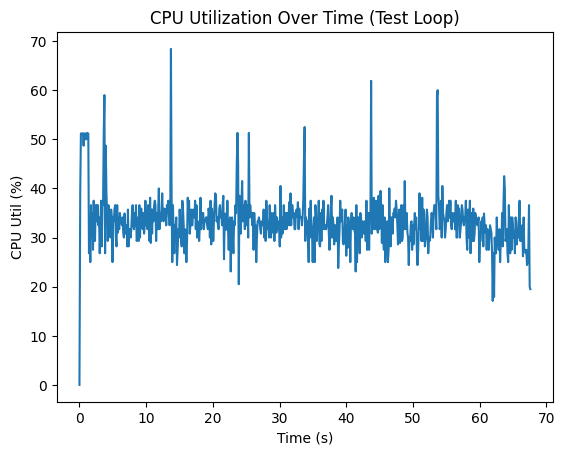

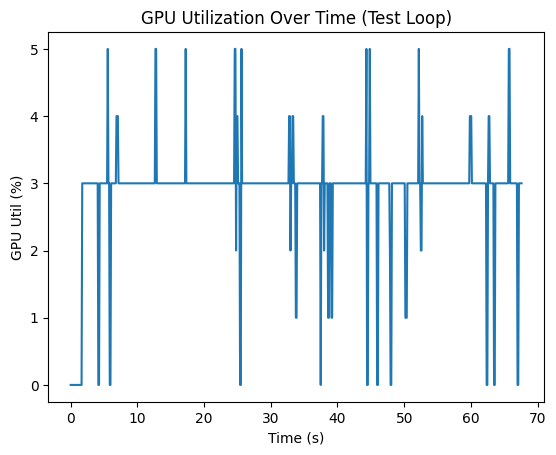

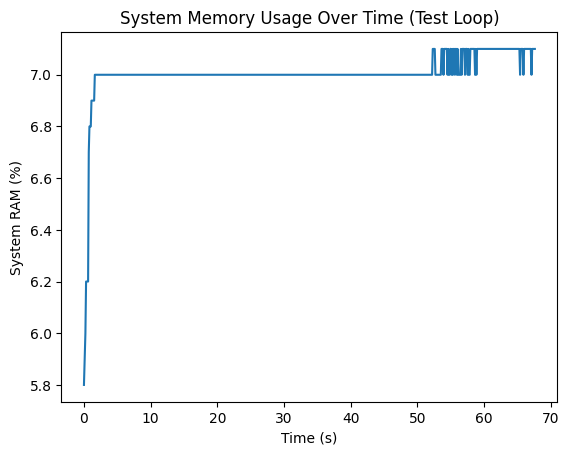

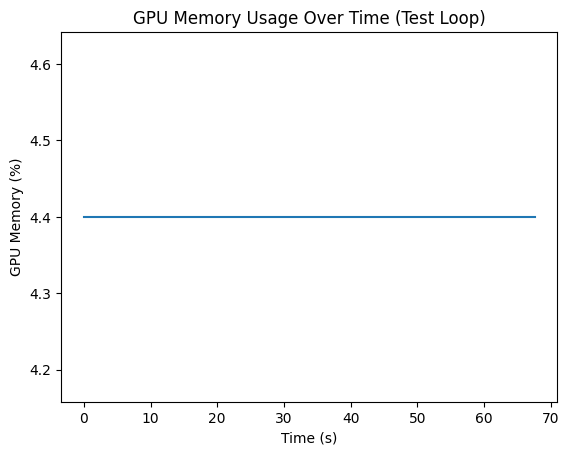

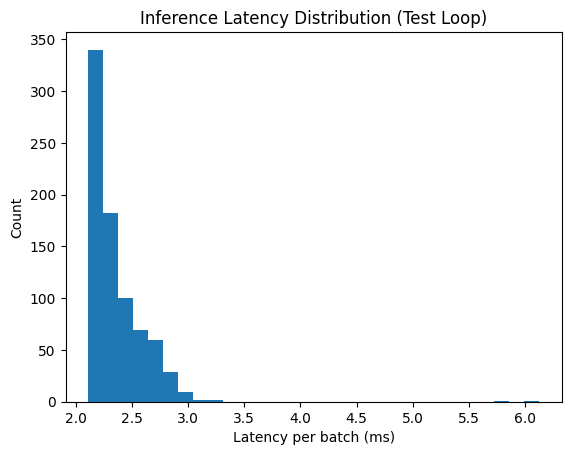

In [14]:
# ADD: visualize traces and latency distribution
plot_util_trace(sampler.data, title_suffix="(Test Loop)")
plot_latency_hist(latencies_ms, title_suffix="(Test Loop)")

In [15]:
import time
import torch.nn.functional as F

# Move model to device (if not already)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get one batch from the validation loader
data_iter = iter(test_loader)
raw_batch, mel_batch, labels_batch = next(data_iter)

# Pick one sample (e.g. index 0)
raw_sample = raw_batch[2].unsqueeze(0).to(device)  # move to GPU
mel_sample = mel_batch[2].unsqueeze(0).to(device)  # move to GPU
label = labels_batch[2].item()

# Start timing
start_time = time.time()

# Run inference
model.eval()
with torch.no_grad():
    output = model(raw_sample, mel_sample)
    prediction = torch.argmax(output, dim=1).item()
    probs = F.softmax(output, dim=1)
    confidence = probs[0][prediction].item()

end_time = time.time()
inference_time = end_time - start_time

# Print results
print(f"True Label: {'FAKE' if label == 1 else 'REAL'}")
print(f"Prediction: {'FAKE' if prediction == 1 else 'REAL'} ({confidence*100:.2f}%)")
print(f"Inference Time: {inference_time:.4f} seconds")

True Label: REAL
Prediction: REAL (100.00%)
Inference Time: 0.0266 seconds
